In [1]:
import pandas as pd

k_df = pd.read_csv("small_locations.csv")
print(len(k_df))
k_df.head()

5


,k,x,y,depo_flag
0,p,0,0,1
1,s1,-2,0,0
2,s2,-2,-2,0
3,s3,4,0,0
4,s4,4,2,0


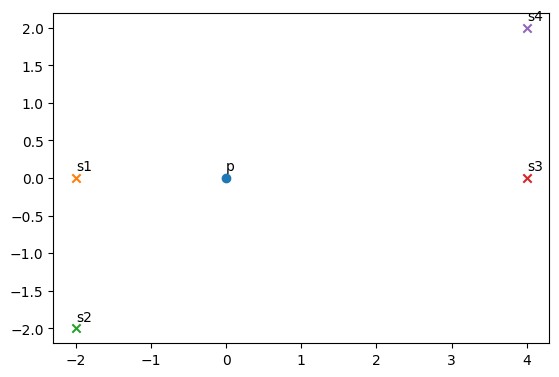

In [2]:
import matplotlib.pyplot as plt

fig = plt.subplot()
fig.set_aspect("equal")
for row in k_df.itertuples():
    if row.depo_flag:
        fig.scatter(row.x, row.y, marker="o")
    else:
        fig.scatter(row.x, row.y, marker="x")
    fig.annotate(row.k, (row.x, row.y + 0.1))
plt.show()

In [3]:
kk_df = pd.read_csv("small_distances.csv")
print(len(kk_df))
kk_df.head()

25


,k1,k2,t
0,p,p,0.000000
1,p,s1,2.000000
2,p,s2,2.828427
3,p,s3,4.000000
4,p,s4,4.472136


In [4]:
r_df = pd.read_csv("small_orders.csv")
print(len(r_df))
r_df.head()

8


,r,s,w,b,e
0,r1,s1,1000,1,1
1,r2,s2,1000,1,2
2,r3,s3,1000,2,2
3,r4,s4,1500,2,3
4,r5,s1,1500,2,4


In [5]:
D = list(range(r_df.b.min(), r_df.e.max() + 1))

p = k_df[k_df.depo_flag == 1].k.tolist()[0]

S = k_df[k_df.depo_flag == 0].k.tolist()

K = [p] + S

R = r_df.r.tolist()

DKK = [(d, k1, k2) for d in D for k1 in K for k2 in K]
DR = [(d, r) for d in D for r in R]
DK = [(d, k) for d in D for k in K]

print(D)
print(K)
print(R)
print(DKK[:5])
print(DR[:5])
print(DK[:5])

[1, 2, 3, 4]
['p', 's1', 's2', 's3', 's4']
['r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8']
[(1, 'p', 'p'), (1, 'p', 's1'), (1, 'p', 's2'), (1, 'p', 's3'), (1, 'p', 's4')]
[(1, 'r1'), (1, 'r2'), (1, 'r3'), (1, 'r4'), (1, 'r5')]
[(1, 'p'), (1, 's1'), (1, 's2'), (1, 's3'), (1, 's4')]


In [6]:
R2S = {row.r: row.s for row in r_df.itertuples()}

R2W = {row.r: row.w for row in r_df.itertuples()}

R2B = {row.r: row.b for row in r_df.itertuples()}

R2E = {row.r: row.e for row in r_df.itertuples()}

KK2T = {(row.k1, row.k2): row.t for row in kk_df.itertuples()}

print("R2S:", R2S)
print("R2W:", R2W)
print("R2B:", R2B)
print("R2E:", R2E)
print("KK2T:", KK2T)

R2S: {'r1': 's1', 'r2': 's2', 'r3': 's3', 'r4': 's4', 'r5': 's1', 'r6': 's2', 'r7': 's3', 'r8': 's4'}
R2W: {'r1': 1000, 'r2': 1000, 'r3': 1000, 'r4': 1500, 'r5': 1500, 'r6': 1500, 'r7': 1500, 'r8': 3000}
R2B: {'r1': 1, 'r2': 1, 'r3': 2, 'r4': 2, 'r5': 2, 'r6': 3, 'r7': 3, 'r8': 4}
R2E: {'r1': 1, 'r2': 2, 'r3': 2, 'r4': 3, 'r5': 4, 'r6': 4, 'r7': 4, 'r8': 4}
KK2T: {('p', 'p'): 0.0, ('p', 's1'): 2.0, ('p', 's2'): 2.8284271247461903, ('p', 's3'): 4.0, ('p', 's4'): 4.47213595499958, ('s1', 'p'): 2.0, ('s1', 's1'): 0.0, ('s1', 's2'): 2.0, ('s1', 's3'): 6.0, ('s1', 's4'): 6.324555320336759, ('s2', 'p'): 2.8284271247461903, ('s2', 's1'): 2.0, ('s2', 's2'): 0.0, ('s2', 's3'): 6.324555320336759, ('s2', 's4'): 7.211102550927978, ('s3', 'p'): 4.0, ('s3', 's1'): 6.0, ('s3', 's2'): 6.324555320336759, ('s3', 's3'): 0.0, ('s3', 's4'): 2.0, ('s4', 'p'): 4.47213595499958, ('s4', 's1'): 6.324555320336759, ('s4', 's2'): 7.211102550927978, ('s4', 's3'): 2.0, ('s4', 's4'): 0.0}


In [7]:
import pulp

prob = pulp.LpProblem("vrp_small", pulp.LpMinimize)

x = pulp.LpVariable.dicts("x", DKK, cat="Binary")
u = pulp.LpVariable.dicts("u", DK, cat="Integer", lowBound=0)
y = pulp.LpVariable.dicts("y", DR, cat="Binary")
h = pulp.LpVariable.dicts("h", D, cat="Continuous", lowBound=0)

for d in D:
    for k1 in K:
        prob += pulp.lpSum([x[d, k1, k2] for k2 in K]) == pulp.lpSum(
            [x[d, k2, k1] for k2 in K]
        )

        prob += pulp.lpSum([x[d, k2, k1] for k2 in K]) <= 1

for d in D:
    prob += u[d, p] == 0

    for s in S:
        prob += 1 <= u[d, s]
        prob += u[d, s] <= len(K) - 1

    for s1 in S:
        for s2 in S:
            prob += u[d, s1] + 1 <= u[d, s2] + (len(K) - 1) * (1 - x[d, s1, s2])

for r in R:
    prob += pulp.lpSum([y[d, r] for d in D]) <= 1

for d in D:
    for r in R:
        tar_s = R2S[r]
        prob += y[d, r] <= pulp.lpSum(x[d, k, tar_s] for k in K)

for d in D:
    prob += pulp.lpSum([y[d, r] * R2W[r] for r in R]) <= 4000

for d in D:
    prob += (
        pulp.lpSum([KK2T[k1, k2] * x[d, k1, k2] for k1 in K for k2 in K]) - 8 <= h[d]
    )

for d in D:
    prob += h[d] <= 3

for r in R:
    for d in D:
        if d < R2B[r]:
            prob += y[d, r] == 0
        if R2E[r] < d:
            prob += y[d, r] == 0

zangyo = pulp.lpSum([3000 * h[d] for d in D])
gaityu = pulp.lpSum([46 * R2W[r] * (1 - pulp.lpSum(y[d, r] for d in D)) for r in R])
prob += zangyo + gaityu

solver = pulp.PULP_CBC_CMD()
status = prob.solve(solver)
print("ステータス:", pulp.LpStatus[status])

print("残業費用:{:.0f}[円]".format(zangyo.value()))
print("外注費用:{:.0f}[円]".format(gaityu.value()))
print("費用合計:{:.0f}[円]".format(zangyo.value() + gaityu.value()))

ステータス: Optimal
残業費用:10249[円]
外注費用:69000[円]
費用合計:79249[円]


In [8]:
for d in D:
    X = [(k1, k2) for k1 in K for k2 in K if x[d, k1, k2].value() == 1]

    time = sum([KK2T[k1, k2] for k1, k2 in X])
    print("---配送日:{}日目---".format(d))
    print("配送重量:{}[kg]".format(sum([y[d, r].value() * R2W[r] for r in R])))
    print("移動時間:{:.2f}[h]".format(time))
    print("残業時間:{:.2f}[h]".format(h[d].value()))
    print("x:", X)

    tar = p
    Route = [p]
    while len(X) >= 1:
        for k1, k2 in X:
            if k1 == tar:
                tar = k2
                Route.append(k2)
                X.remove((k1, k2))

    print("u:", [u[d, k].value() for k in Route])
    print("配送ルート:", "->".join(Route))

---配送日:1日目---
配送重量:2000.0[kg]
移動時間:6.83[h]
残業時間:0.00[h]
x: [('p', 's2'), ('s1', 'p'), ('s2', 's1')]
u: [0.0, 1.0, 4.0, 0.0]
配送ルート: p->s2->s1->p
---配送日:2日目---
配送重量:2500.0[kg]
移動時間:10.47[h]
残業時間:2.47[h]
x: [('p', 's3'), ('s3', 's4'), ('s4', 'p')]
u: [0.0, 1.0, 4.0, 0.0]
配送ルート: p->s3->s4->p
---配送日:3日目---
配送重量:3000.0[kg]
移動時間:6.83[h]
残業時間:0.00[h]
x: [('p', 's2'), ('s1', 'p'), ('s2', 's1')]
u: [0.0, 1.0, 4.0, 0.0]
配送ルート: p->s2->s1->p
---配送日:4日目---
配送重量:3000.0[kg]
移動時間:8.94[h]
残業時間:0.94[h]
x: [('p', 's4'), ('s4', 'p')]
u: [0.0, 4.0, 0.0]
配送ルート: p->s4->p


In [9]:
for r in R:
    owned_truck_flag = sum([y[d, r].value() for d in D])
    if owned_truck_flag:
        tar_d = [d for d in D if y[d, r].value() == 1][0]
        text = "荷物{}(お店{},{}[kg])-配送日:{}日目".format(r, R2S[r], R2W[r], tar_d)
    else:
        gc = 46 * R2W[r]
        text = "荷物{}(お店{},{}[kg])-外注費用:{}[円]".format(r, R2S[r], R2W[r], gc)
    print(text)

荷物r1(お店s1,1000[kg])-配送日:1日目
荷物r2(お店s2,1000[kg])-配送日:1日目
荷物r3(お店s3,1000[kg])-配送日:2日目
荷物r4(お店s4,1500[kg])-配送日:2日目
荷物r5(お店s1,1500[kg])-配送日:3日目
荷物r6(お店s2,1500[kg])-配送日:3日目
荷物r7(お店s3,1500[kg])-外注費用:69000[円]
荷物r8(お店s4,3000[kg])-配送日:4日目


In [10]:
k_df = pd.read_csv("locations.csv")
print(len(k_df))
k_df.head()

10


,k,x,y,depo_flag
0,p,0.000000,0.000000,1
1,s1,0.529473,-0.397044,0
2,s2,2.916925,-0.302511,0
3,s3,0.131532,1.898977,0
4,s4,-1.091079,-0.709964,0


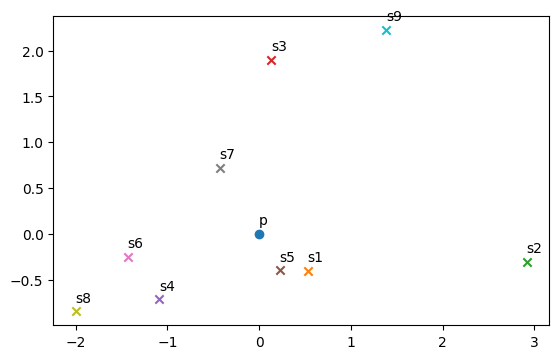

In [11]:
fig = plt.subplot()
fig.set_aspect("equal")
for row in k_df.itertuples():
    if row.depo_flag:
        fig.scatter(row.x, row.y, marker="o")
    else:
        fig.scatter(row.x, row.y, marker="x")
    fig.annotate(row.k, (row.x, row.y + 0.1))
plt.show()

In [12]:
kk_df = pd.read_csv("distances.csv")
print(len(kk_df))
kk_df.head()

100


,k1,k2,t
0,p,p,0.000000
1,p,s1,0.661805
2,p,s2,2.932570
3,p,s3,1.903527
4,p,s4,1.301730


In [13]:
r_df = pd.read_csv("orders.csv")
print(len(r_df))
r_df.head()

100


,r,s,w,b,e
0,r00,s4,1000,17,18
1,r01,s1,950,16,18
2,r02,s6,1330,2,4
3,r03,s5,1130,19,20
4,r04,s2,710,1,2


In [14]:
D = list(range(r_df.b.min(), r_df.e.max() + 1))

p = k_df[k_df.depo_flag == 1].k.tolist()[0]

S = k_df[k_df.depo_flag == 0].k.tolist()

K = [p] + S

R = r_df.r.tolist()

DKK = [(d, k1, k2) for d in D for k1 in K for k2 in K]
DR = [(d, r) for d in D for r in R]
DK = [(d, k) for d in D for k in K]

print(D)
print(K)
print(R[:5])
print(DKK[:5])
print(DR[:5])
print(DK[:5])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
['p', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9']
['r00', 'r01', 'r02', 'r03', 'r04']
[(1, 'p', 'p'), (1, 'p', 's1'), (1, 'p', 's2'), (1, 'p', 's3'), (1, 'p', 's4')]
[(1, 'r00'), (1, 'r01'), (1, 'r02'), (1, 'r03'), (1, 'r04')]
[(1, 'p'), (1, 's1'), (1, 's2'), (1, 's3'), (1, 's4')]


In [15]:
R2S = {row.r: row.s for row in r_df.itertuples()}

R2W = {row.r: row.w for row in r_df.itertuples()}

R2B = {row.r: row.b for row in r_df.itertuples()}

R2E = {row.r: row.e for row in r_df.itertuples()}

KK2T = {(row.k1, row.k2): row.t for row in kk_df.itertuples()}

print("R2S:", R2S)
print("R2W:", R2W)
print("R2B:", R2B)
print("R2E:", R2E)
print("KK2T:", KK2T)

R2S: {'r00': 's4', 'r01': 's1', 'r02': 's6', 'r03': 's5', 'r04': 's2', 'r05': 's5', 'r06': 's3', 'r07': 's4', 'r08': 's2', 'r09': 's6', 'r10': 's9', 'r11': 's3', 'r12': 's1', 'r13': 's7', 'r14': 's9', 'r15': 's3', 'r16': 's5', 'r17': 's7', 'r18': 's4', 'r19': 's9', 'r20': 's6', 'r21': 's8', 'r22': 's4', 'r23': 's9', 'r24': 's2', 'r25': 's3', 'r26': 's5', 'r27': 's5', 'r28': 's2', 'r29': 's4', 'r30': 's4', 'r31': 's1', 'r32': 's7', 'r33': 's8', 'r34': 's5', 'r35': 's6', 'r36': 's1', 'r37': 's7', 'r38': 's7', 'r39': 's2', 'r40': 's4', 'r41': 's3', 'r42': 's7', 'r43': 's5', 'r44': 's2', 'r45': 's9', 'r46': 's9', 'r47': 's7', 'r48': 's2', 'r49': 's9', 'r50': 's7', 'r51': 's7', 'r52': 's6', 'r53': 's9', 'r54': 's5', 'r55': 's5', 'r56': 's4', 'r57': 's8', 'r58': 's6', 'r59': 's3', 'r60': 's2', 'r61': 's7', 'r62': 's1', 'r63': 's5', 'r64': 's7', 'r65': 's8', 'r66': 's8', 'r67': 's1', 'r68': 's7', 'r69': 's2', 'r70': 's1', 'r71': 's2', 'r72': 's3', 'r73': 's3', 'r74': 's1', 'r75': 's2', 'r76':

In [16]:
import pulp

prob = pulp.LpProblem("vrp", pulp.LpMinimize)

x = pulp.LpVariable.dicts("x", DKK, cat="Binary")
u = pulp.LpVariable.dicts("u", DK, cat="Integer", lowBound=0)
y = pulp.LpVariable.dicts("y", DR, cat="Binary")
h = pulp.LpVariable.dicts("h", D, cat="Continuous", lowBound=0)

for d in D:
    for k1 in K:
        prob += pulp.lpSum([x[d, k1, k2] for k2 in K]) == pulp.lpSum(
            [x[d, k2, k1] for k2 in K]
        )

        prob += pulp.lpSum([x[d, k2, k1] for k2 in K]) <= 1

for d in D:
    prob += u[d, p] == 0

    for s in S:
        prob += 1 <= u[d, s]
        prob += u[d, s] <= len(K) - 1

    for s1 in S:
        for s2 in S:
            prob += u[d, s1] + 1 <= u[d, s2] + (len(K) - 1) * (1 - x[d, s1, s2])

for r in R:
    prob += pulp.lpSum([y[d, r] for d in D]) <= 1

for d in D:
    for r in R:
        tar_s = R2S[r]
        prob += y[d, r] <= pulp.lpSum(x[d, k, tar_s] for k in K)

for d in D:
    prob += pulp.lpSum([y[d, r] * R2W[r] for r in R]) <= 4000

for d in D:
    prob += (
        pulp.lpSum([KK2T[k1, k2] * x[d, k1, k2] for k1 in K for k2 in K]) - 8 <= h[d]
    )

for d in D:
    prob += h[d] <= 3

for r in R:
    for d in D:
        if d < R2B[r]:
            prob += y[d, r] == 0
        if R2E[r] < d:
            prob += y[d, r] == 0

zangyo = pulp.lpSum([3000 * h[d] for d in D])
gaityu = pulp.lpSum([46 * R2W[r] * (1 - pulp.lpSum(y[d, r] for d in D)) for r in R])
prob += zangyo + gaityu

solver = pulp.PULP_CBC_CMD(gapRel=0.1)
status = prob.solve(solver)
print("ステータス:", pulp.LpStatus[status])

print("残業費用:{:.0f}[円]".format(zangyo.value()))
print("外注費用:{:.0f}[円]".format(gaityu.value()))
print("費用合計:{:.0f}[円]".format(zangyo.value() + gaityu.value()))

ステータス: Optimal
残業費用:58324[円]
外注費用:1202900[円]
費用合計:1261224[円]


In [17]:
for d in D:
    X = [(k1, k2) for k1 in K for k2 in K if x[d, k1, k2].value() == 1]

    time = sum([KK2T[k1, k2] for k1, k2 in X])
    print("---配送日:{}日目---".format(d))
    print("配送重量:{}[kg]".format(sum([y[d, r].value() * R2W[r] for r in R])))
    print("移動時間:{:.2f}[h]".format(time))
    print("残業時間:{:.2f}[h]".format(h[d].value()))

    tar = p
    Route = [p]
    while len(X) >= 1:
        for k1, k2 in X:
            if k1 == tar:
                tar = k2
                Route.append(k2)
                X.remove((k1, k2))

    print("配送ルート:", "->".join(Route))

---配送日:1日目---
配送重量:3510.0[kg]
移動時間:10.40[h]
残業時間:2.40[h]
配送ルート: p->s9->s3->s2->p
---配送日:2日目---
配送重量:3770.0[kg]
移動時間:5.37[h]
残業時間:0.00[h]
配送ルート: p->s8->s6->s4->s5->p
---配送日:3日目---
配送重量:3880.0[kg]
移動時間:7.79[h]
残業時間:0.00[h]
配送ルート: p->s8->s6->s3->s7->p
---配送日:4日目---
配送重量:3970.0[kg]
移動時間:6.23[h]
残業時間:0.00[h]
配送ルート: p->s5->s4->s7->s6->p
---配送日:5日目---
配送重量:3680.0[kg]
移動時間:8.34[h]
残業時間:0.34[h]
配送ルート: p->s4->s9->s3->p
---配送日:6日目---
配送重量:3600.0[kg]
移動時間:9.82[h]
残業時間:1.82[h]
配送ルート: p->s7->s9->s2->s5->s1->p
---配送日:7日目---
配送重量:3980.0[kg]
移動時間:10.82[h]
残業時間:2.82[h]
配送ルート: p->s2->s7->s8->p
---配送日:8日目---
配送重量:3950.0[kg]
移動時間:5.47[h]
残業時間:0.00[h]
配送ルート: p->s3->s7->s5->s1->p
---配送日:9日目---
配送重量:3850.0[kg]
移動時間:9.33[h]
残業時間:1.33[h]
配送ルート: p->s2->s9->s3->s7->p
---配送日:10日目---
配送重量:3620.0[kg]
移動時間:9.93[h]
残業時間:1.93[h]
配送ルート: p->s7->s2->s9->p
---配送日:11日目---
配送重量:3690.0[kg]
移動時間:9.29[h]
残業時間:1.29[h]
配送ルート: p->s1->s4->s5->s2->p
---配送日:12日目---
配送重量:3990.0[kg]
移動時間:9.31[h]
残業時間:1.31[h]
配送ルート: p->s7->s9->s2->s5->p

In [18]:
for r in R:
    owned_truck_flag = sum([y[d, r].value() for d in D])
    if owned_truck_flag:
        tar_d = [d for d in D if y[d, r].value() == 1][0]
        text = "荷物{}(お店{},{}[kg])-配送日:{}日目".format(r, R2S[r], R2W[r], tar_d)
    else:
        gc = 46 * R2W[r]
        text = "荷物{}(お店{},{}[kg])-外注費用:{}[円]".format(r, R2S[r], R2W[r], gc)
    print(text)

荷物r00(お店s4,1000[kg])-配送日:17日目
荷物r01(お店s1,950[kg])-外注費用:43700[円]
荷物r02(お店s6,1330[kg])-配送日:2日目
荷物r03(お店s5,1130[kg])-配送日:20日目
荷物r04(お店s2,710[kg])-配送日:1日目
荷物r05(お店s5,690[kg])-配送日:12日目
荷物r06(お店s3,1180[kg])-配送日:14日目
荷物r07(お店s4,690[kg])-配送日:5日目
荷物r08(お店s2,960[kg])-外注費用:44160[円]
荷物r09(お店s6,930[kg])-外注費用:42780[円]
荷物r10(お店s9,910[kg])-外注費用:41860[円]
荷物r11(お店s3,1100[kg])-配送日:8日目
荷物r12(お店s1,1360[kg])-配送日:13日目
荷物r13(お店s7,1120[kg])-配送日:19日目
荷物r14(お店s9,820[kg])-配送日:9日目
荷物r15(お店s3,650[kg])-外注費用:29900[円]
荷物r16(お店s5,1590[kg])-配送日:16日目
荷物r17(お店s7,930[kg])-外注費用:42780[円]
荷物r18(お店s4,880[kg])-外注費用:40480[円]
荷物r19(お店s9,1470[kg])-配送日:10日目
荷物r20(お店s6,1020[kg])-配送日:4日目
荷物r21(お店s8,2020[kg])-外注費用:92920[円]
荷物r22(お店s4,790[kg])-配送日:11日目
荷物r23(お店s9,890[kg])-配送日:6日目
荷物r24(お店s2,1160[kg])-配送日:14日目
荷物r25(お店s3,560[kg])-配送日:3日目
荷物r26(お店s5,1440[kg])-配送日:16日目
荷物r27(お店s5,900[kg])-外注費用:41400[円]
荷物r28(お店s2,1230[kg])-配送日:15日目
荷物r29(お店s4,1020[kg])-配送日:5日目
荷物r30(お店s4,1020[kg])-配送日:17日目
荷物r31(お店s1,1080[kg])-配送日:8日目
荷物r32(お店s7,1110[kg])

In [19]:
resD2S = {d: set() for d in D}
for d, r in y:
    if y[d, r].value() == 1:
        resD2S[d].add(R2S[r])

for d in D:
    print("---配送日:{}日目---".format(d))
    X = [(k1, k2) for k1 in K for k2 in K if x[d, k1, k2].value() == 1]
    time = sum([KK2T[k1, k2] for k1, k2 in X])
    print("移動時間:{:.2f}[h]".format(time))
    routeS = set([k1 for k1, k2 in X]) - set([p])
    print("(A)配送ルートのお店:", routeS)
    targetS = resD2S[d]
    print("(B)荷物の注文があるお店:", targetS)

    print("(A)-(B):", routeS - targetS)

---配送日:1日目---
移動時間:10.40[h]
(A)配送ルートのお店: {'s3', 's2', 's9'}
(B)荷物の注文があるお店: {'s2', 's9'}
(A)-(B): {'s3'}
---配送日:2日目---
移動時間:5.37[h]
(A)配送ルートのお店: {'s6', 's4', 's8', 's5'}
(B)荷物の注文があるお店: {'s6', 's4', 's8'}
(A)-(B): {'s5'}
---配送日:3日目---
移動時間:7.79[h]
(A)配送ルートのお店: {'s3', 's8', 's7', 's6'}
(B)荷物の注文があるお店: {'s3', 's8', 's6'}
(A)-(B): {'s7'}
---配送日:4日目---
移動時間:6.23[h]
(A)配送ルートのお店: {'s6', 's4', 's5', 's7'}
(B)荷物の注文があるお店: {'s6', 's4', 's5', 's7'}
(A)-(B): set()
---配送日:5日目---
移動時間:8.34[h]
(A)配送ルートのお店: {'s3', 's4', 's9'}
(B)荷物の注文があるお店: {'s3', 's4', 's9'}
(A)-(B): set()
---配送日:6日目---
移動時間:9.82[h]
(A)配送ルートのお店: {'s1', 's9', 's7', 's5', 's2'}
(B)荷物の注文があるお店: {'s1', 's9', 's7', 's2'}
(A)-(B): {'s5'}
---配送日:7日目---
移動時間:10.82[h]
(A)配送ルートのお店: {'s2', 's8', 's7'}
(B)荷物の注文があるお店: {'s2', 's8'}
(A)-(B): {'s7'}
---配送日:8日目---
移動時間:5.47[h]
(A)配送ルートのお店: {'s3', 's1', 's5', 's7'}
(B)荷物の注文があるお店: {'s3', 's1', 's5', 's7'}
(A)-(B): set()
---配送日:9日目---
移動時間:9.33[h]
(A)配送ルートのお店: {'s3', 's9', 's2', 's7'}
(B)荷物の注文があるお店: {'s9', 

In [ ]:
import matplotlib.pyplot as plt

K2XY = {row.k: (row.x, row.y) for row in k_df.itertuples()}

fig = plt.figure(figsize=(12, 20))
for i in range(len(D)):
    d = D[i]
    X = [(k1, k2) for k1 in K for k2 in K if x[d, k1, k2].value() == 1]
    routeK = [k1 for k1, k2 in X]
    time = sum(KK2T[k1, k2] for k1, k2 in X)
    title_text = "day:{}({:.1f}[h])".format(d, time)
    ax = fig.add_subplot(
        5, 4, i + 1, xlim=(-3.5, 3.5), ylim=(-3.5, 3.5), title=title_text
    )
    ax.set_aspect("equal")

    for row in k_df.itertuples():
        if row.k in routeK:
            if row.depo_flag:
                ax.scatter(row.x, row.y, marker="o")
            else:
                ax.scatter(row.x, row.y, marker="x")

    for k1, k2 in X:
        (x1, y1) = K2XY[k1]
        (x2, y2) = K2XY[k2]
        ax.arrow(
            x1, y1, (x2 - x1), (y2 - y1), head_width=0.2, length_includes_head=True
        )